## One-Step Evaluation Script


--- Dataset Info ---
<class 'pandas.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             48842 non-null  int64
 1   workclass       47879 non-null  str  
 2   fnlwgt          48842 non-null  int64
 3   education       48842 non-null  str  
 4   education-num   48842 non-null  int64
 5   marital-status  48842 non-null  str  
 6   occupation      47876 non-null  str  
 7   relationship    48842 non-null  str  
 8   race            48842 non-null  str  
 9   sex             48842 non-null  str  
 10  capital-gain    48842 non-null  int64
 11  capital-loss    48842 non-null  int64
 12  hours-per-week  48842 non-null  int64
 13  native-country  48568 non-null  str  
 14  income          48842 non-null  str  
dtypes: int64(6), str(9)
memory usage: 5.6 MB
None

--- Target Class Distribution ---
income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.    

/var/folders/nh/y98th5z14yvby709c0r24ztc0000gn/T/ipykernel_23362/2872815661.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income', data=df, palette='Set2')


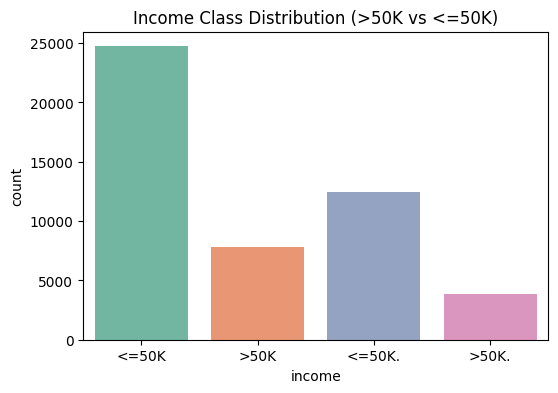


--- Missing Values Count ---
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64


/var/folders/nh/y98th5z14yvby709c0r24ztc0000gn/T/ipykernel_23362/2872815661.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='income', y='education-num', data=df, palette='mako')


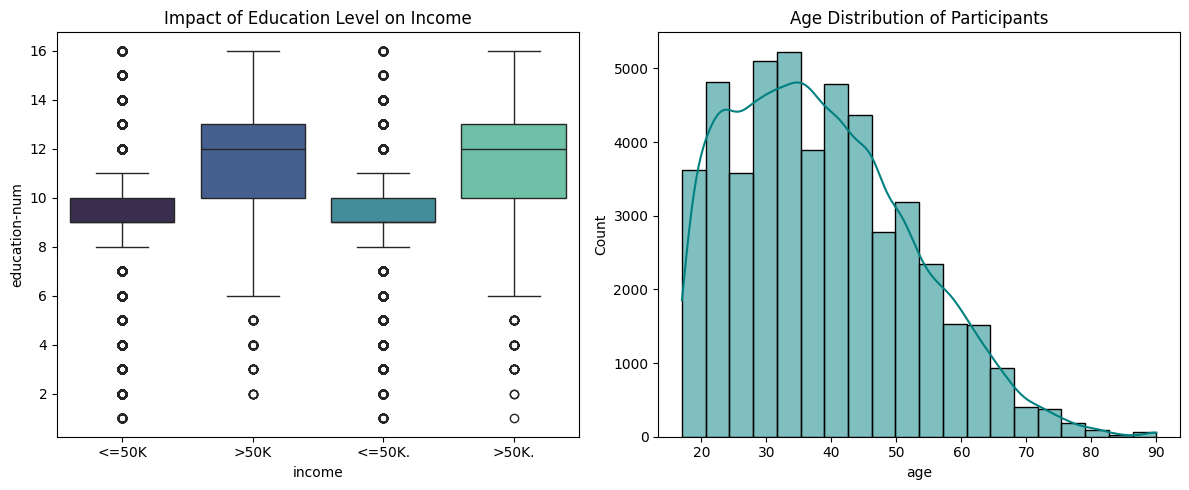

In [6]:
 #One-Step Data Loading and EDA

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 

# 1. Load the dataset (ID 2 represents the Adult Census Income dataset) [2]
adult = fetch_ucirepo(id=2) 
X = adult.data.features 
y = adult.data.targets 
df = pd.concat([X, y], axis=1)

# 2. Dataset Summary and Structure [1], [3]
print("--- Dataset Info ---")
print(df.info())
print("\n--- Target Class Distribution ---")
print(df['income'].value_counts())

# 3. Visualizing Target Class Imbalance [1], [4]
plt.figure(figsize=(6, 4))
sns.countplot(x='income', data=df, palette='Set2')
plt.title('Income Class Distribution (>50K vs <=50K)')
plt.show()

# 4. Checking for Missing Values (represented as '?' in raw data) [3], [5]
df_cleaned = df.replace('?', np.nan)
print("\n--- Missing Values Count ---")
print(df_cleaned.isnull().sum())

# 5. Visualizing High-Impact Numeric Features [3], [6]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Education Level vs Income
sns.boxplot(ax=axes[0], x='income', y='education-num', data=df, palette='mako')
axes[0].set_title('Impact of Education Level on Income')

# Age Distribution [1]
sns.histplot(ax=axes[1], x='age', data=df, bins=20, kde=True, color='teal')
axes[1].set_title('Age Distribution of Participants')

plt.tight_layout()
plt.show()


### EVALUTION

In [7]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# 1. Load the dataset (ID 2 = Adult Census)
adult = fetch_ucirepo(id=2) 
X = adult.data.features.copy()
y = adult.data.targets.copy()

# 2. Preprocessing Training Data
# Strip whitespace from categorical data [3]
X = X.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
y = y.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Replace '?' missing values with Mode [4]
X = X.replace('?', np.nan)
X = X.fillna(X.mode().iloc)

# Drop noise/redundant columns: fnlwgt (pop estimate) and education (mapped to education-num) [1, 4]
X = X.drop(columns=['fnlwgt', 'education'])
y_mapped = y['income'].map({'>50K': 1, '<=50K': 0, '>50K.': 1, '<=50K.': 0})

# One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Split for internal validation
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y_mapped, test_size=0.2, random_state=42)

# 3. Train Model (Gradient Boosting typically yields best F1)
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# 4. Evaluation with Adjusted Threshold (0.2)
# Using raw probabilities to overcome class imbalance (76/24 split) [5]
y_probs = model.predict_proba(X_val)[:, 1]
custom_threshold = 0.2
y_pred_adj = (y_probs >= custom_threshold).astype(int)

# 5. Output Final Metrics
print(f"--- Evaluation Results (Threshold: {custom_threshold}) ---")
print(f"Overall Accuracy: {accuracy_score(y_val, y_pred_adj):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_adj, target_names=['<=50K', '>50K']))


--- Evaluation Results (Threshold: 0.2) ---
Overall Accuracy: 0.8045

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.96      0.78      0.86      7414
        >50K       0.56      0.89      0.69      2355

    accuracy                           0.80      9769
   macro avg       0.76      0.83      0.77      9769
weighted avg       0.86      0.80      0.82      9769

